In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import yaml

with open('config.yaml') as f:
    config = yaml.safe_load(f)

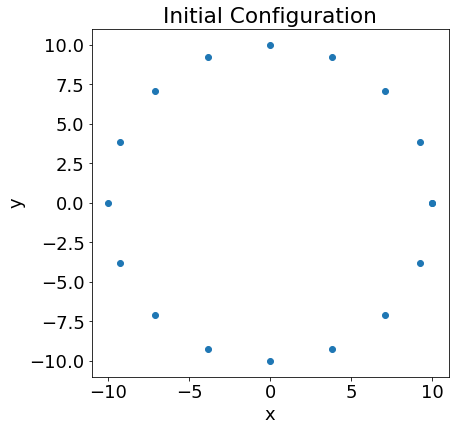

In [2]:
%matplotlib inline

n = config['numberofparticles']
R = config['radius']
x = np.zeros(n)
y = np.zeros(n)
theta = np.deg2rad(np.linspace(0,360,n,endpoint=True))

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4,6.4))
plt.title('Initial Configuration')
plt.xlabel('x')
plt.ylabel('y')
x = R*np.cos(theta)
y = R*np.sin(theta)
plt.scatter(x,y)

If you rotate gravitational wave (GW) of one polarization by 90 degrees along its axis of propagation, you get the GW of same polarization, only shifted in phase. Therefore, GW of another polarization, to be linearly independent, must be rotated between 0 and 90 degrees and 45 degrees are exactly between those two.

For comparison, if you rotate EM wave of one polarization by 180 degrees, you get EM wave of same polarization, only shifted in phase.

That's why polarizations of EM waves are at 90 degrees to each other, while polarizations of GWs are at 45 degrees to each other.

https://math.stackexchange.com/questions/759356/plus-and-cross-polarizations

In [3]:
def func(R, z=0, ininc=0, T=0.02, inphi=0, inalpha=0, Cpamp=1, Ccamp=0, m1=1.4, m2=1.4):
    n = config['numberofparticles']
    x = R*np.cos(theta)
    y = R*np.sin(theta)
    t = np.arange(100) / 1000
    phi = np.deg2rad(inphi) # initial phase
    inc = np.deg2rad(ininc) # inclination angle
    alpha = np.deg2rad(inalpha)
    forb = 1 / T
    omega = 2*np.pi/T
    k = omega

    Cplus = Cpamp * R/40 * (1+np.cos(inc)**2)/2
    Ccross = Ccamp * R/40 * np.cos(inc)

    mu = m1*m2/(m1+m2)
    M = m1 + m2
    eta = mu/M
    Mc = mu**0.6 * M**0.4

    xt = np.zeros([np.size(t), n], dtype=np.complex_)
    yt = np.zeros([np.size(t), n], dtype=np.complex_)
    xplus = np.zeros([np.size(t), n], dtype=np.complex_)
    xcross = np.zeros([np.size(t), n], dtype=np.complex_)
    yplus = np.zeros([np.size(t), n], dtype=np.complex_)
    ycross = np.zeros([np.size(t), n], dtype=np.complex_)

    for i in range(n):
        # Assuming 
        ## 1. wave propagating along z 
        ## 2. at z=0
        fdot = (forb)**(11/3) * Mc**(5/3) / 20000
        gwphase = omega*t + np.pi*fdot*t**2
        xplus[:,i] = (1 + 1/2*Cplus*np.exp(1j*(omega*t - k*z + phi))) * x[i] 
        yplus[:,i] = (1 - 1/2*Cplus*np.exp(1j*(omega*t - k*z + phi))) * y[i]
        xcross[:,i] = x[i] + 1/2*Ccross*np.exp(1j*(omega*t - k*z + phi)) * y[i]
        ycross[:,i] = y[i] + 1/2*Ccross*np.exp(1j*(omega*t - k*z + phi)) * x[i]
        xt[:,i] = np.sqrt(R**2 - (Cplus*(x[i]**2 - y[i]**2) + Ccross*2*x[i]*y[i]) * np.exp(1j*(gwphase - k*z + phi))) * x[i] / R
        yt[:,i] = np.sqrt(R**2 - (Cplus*(x[i]**2 - y[i]**2) + Ccross*2*x[i]*y[i]) * np.exp(1j*(gwphase - k*z + phi))) * y[i] / R

    # Rotation transformation

    alpha = np.deg2rad(0)
    lorentz = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]])

    xr = (xplus)# + 1j*xcross)
    yr = (yplus)# + 1j*ycross)

    for i in range(np.size(t)):
        for j in range(n):
            xr[i,j], yr[i,j] = np.matmul(lorentz,np.array([xt[i,j],yt[i,j]]))
    
    return xr, yr

# 2D

In [4]:
%matplotlib qt

t = np.arange(100)

fig, ax = plt.subplots(figsize=(6.4,6.4))
ln1, = plt.plot([], [], 'ro')
ln2, = ax.plot([], [], lw=1)
ln3, = ax.plot([0,R/np.sqrt(2)], [0,R/np.sqrt(2)], lw=3)

def init2D():
    ax.set_xlim(-2*R, 2*R)
    ax.set_ylim(-2*R, 2*R)
    return ln1, ln2, ln3

def update2D(frame):
    R = config['radius']
    T = 0.01 # Time period of orbit in ms
    inc = config['inclination_angle']
    m1 = config['mass1']
    m2 = config['mass2']
    mu = m1*m2/(m1+m2)
    M = m1 + m2
    eta = mu/M
    Mc = mu**0.6 * M**0.4
    vel = config['velocity']
    r = config['distance']
    # 10x amplification
    forb = 1 / T
    omega = 2*np.pi/T
    h0 = Mc**(5/3) * forb**(2/3) / r
    hamp = 2e4 * mu * vel**2 / r # /3e19 to convert kpc to m (Similar to prefactors 4G and solar mass conversion)
    Cpamp = hamp * h0 * config['C_plus']
    if (config['C_plus_complex'] == 'yes'):
        Cpamp *= 1j
    Ccamp = hamp * h0 * config['C_cross']
    if (config['C_cross_complex'] == 'yes'):
        Ccamp *= 1j
    xr, yr = func(R, T=T, ininc=inc, Cpamp=Cpamp, Ccamp=Ccamp, m1=m1, m2=m2)
    xdata = np.real(xr[frame])
    ydata = np.real(yr[frame])
    for R in [4,7]:
        xr, yr = func(R, T=T, ininc=inc, Cpamp=Cpamp, Ccamp=Ccamp, m1=m1, m2=m2)
        xdata = np.append(xdata, xr[frame])
        ydata = np.append(ydata, yr[frame])
        
    ln1.set_data(xdata, ydata)
    ln2.set_data(xdata, ydata)
    return ln1, ln2, ln3

ani = FuncAnimation(fig, update2D, frames=len(t),
                    init_func=init2D, interval=120, blit=False)
plt.show()

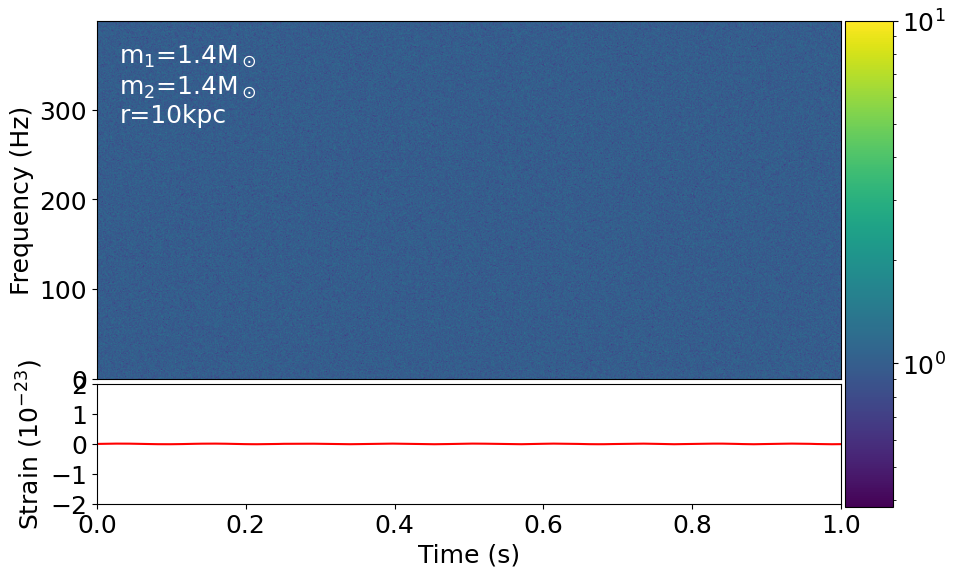

In [5]:
%matplotlib inline

num = 1000
num2 = 400

m1 = config['mass1']
m2 = config['mass2']
Mc = (m1*m2)**0.6/(m1+m2)**0.2
r = config['distance']
h0 = 10
f0 = 50

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(nrows=2, figsize=(9.6, 6.4), gridspec_kw={'height_ratios': [3, 1]}, dpi=100)
plt.subplots_adjust(hspace=.02)
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1].set_ymargin(0.1)
axs[1].set_xmargin(False)

T = np.linspace(0,1,num)
f = np.concatenate([np.ones(num*4//5),np.zeros(num//5)+np.random.normal(0,f0/100,num//5)])
fdot = f0**(11/3) * Mc**(5/3)
h = np.ones(num)
A = np.ones([num2, num])

dt = T[1] - T[0]
f[0] = f0

thickness = 3
for i in range(len(T)-1):
    f[i+1] = f[i] + dt*(f[i])**(11/3) * (Mc)**(5/3)/5e5
    if f[i+1] > config['freq_cutoff']:
        break
    h[i+1] = max(h0*Mc**(5/3)*(f[i]/1)**(2/3) / r / 20, 1)
    A[int(f[i])-thickness:int(f[i])+thickness, i] = h[i]
phi0 = T*f#0 + 0.5*fdot*T**2/1e4

h += np.random.normal(0, h0/50)
A += np.random.normal(0, h0/80, [num2,num])

im = axs[0].imshow(A, aspect='auto', norm=LogNorm())
if np.max(h) < 5:
    axs[1].set_yticks(np.linspace(-10,10, 5, endpoint=True))
    im = axs[0].imshow(A, aspect='auto', norm=LogNorm(vmax=(10)))
divider = make_axes_locatable(axs[0])
cax = fig.add_axes([0.904, 0.12, 0.05, 0.76])
plt.colorbar(im, cax)
axs[0].invert_yaxis()
line = axs[1].plot(T, h/100*np.sin(phi0) + h/4000*np.sin(T*np.random.normal(50,10,num)), c='r')
if np.max(h) < 5:
    axs[1].set_yticks(np.linspace(-2,2, 5, endpoint=True))
axs[1].set_yticks(np.linspace(-2,2, 5, endpoint=True))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Strain ($10^{-23}$)')
axs[0].set_ylabel('Frequency (Hz)')

#plt.subplot_tool()
at = AnchoredText(f'm$_1$={m1}M$_\odot$\nm$_2$={m2}M$_\odot$\nr={r}kpc', prop=dict(size=18, color='white'), frameon=False, loc='upper left')
axs[0].add_artist(at)
#plt.legend()
#plt.savefig('plot1.png', bbox_inches='tight', facecolor='white')

plt.show()

# 3D

In [8]:
%matplotlib qt

t = np.arange(100)

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(9.6,9.6))
ax = Axes3D(fig)
line1, = plt.plot([], [], [], 'o-', color='b', markeredgecolor='r', markerfacecolor='r')

def init():
    R = 10
    ax.set_xlim(-2*R, 2*R)
    ax.set_zlim(-2*R, 2*R)
    ax.set_ylim(0,3)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    return line1

def update(frames):
    line1.set_xdata(X[frames])
    line1.set_ydata(Z[frames])
    line1.set_3d_properties(Y[frames])
    return line1

def tosave(frames):
    R=config['radius']
    z=config['z_dir']
    T=0.01
    ininc = config['inclination_angle']
    m1 = config['mass1']
    m2 = config['mass2']
    mu = m1*m2/(m1+m2)
    vel = config['velocity'] # in terms of speed of light (assuming circular orbit)
    r = config['distance'] # distance to binary system in kpc
    hamp = 1e5 * mu * vel**2 / r # /3e19 to convert kpc to m (Similar to prefactors 4G and solar mass conversion)
    Cpamp = hamp * config['C_plus']
    if (config['C_plus_complex'] == 'yes'):
        Cpamp *= 1j
    Ccamp = hamp * config['C_cross']
    if (config['C_cross_complex'] == 'yes'):
        Ccamp *= 1j
    xr, yr = func(R, T=T, z=z, Cpamp=Cpamp, Ccamp=Ccamp, ininc=ininc, m1=m1, m2=m2)
    xdata = np.real(xr[frames])
    ydata = np.real(yr[frames])
    zdata = z * np.ones(np.size(xdata))
    
    for ziter in np.linspace(0,3,10, endpoint=True):
        for R in [4,7,10]:
            xr, yr = func(R, T=T, z=ziter/1000, Cpamp=Cpamp, Ccamp=Ccamp, ininc=ininc, m1=m1, m2=m2)
            xdata = np.append(xdata, np.real(xr[frames]))
            ydata = np.append(ydata, np.real(yr[frames]))
            zdata = np.append(zdata, ziter * np.ones(n))
    np.savetxt(f'./data/data{k}.csv', np.vstack([xdata,zdata,ydata]), delimiter=',')
    return

global k
for k in range(len(t)):
    tosave(k)
    pass

In [ ]:
%matplotlib qt
t = np.arange(100)
sizea = np.shape(np.loadtxt(f'./data/data0.csv', delimiter=','))

global X, Y, Z
X = np.zeros([100, sizea[1]])
Y = np.zeros([100, sizea[1]])
Z = np.zeros([100, sizea[1]])
for i in range(len(t)):
    X[i], Z[i], Y[i] = np.loadtxt(f'./data/data{i}.csv', delimiter=',')

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(9.6,9.6))
ax = Axes3D(fig)
line1, = plt.plot([], [], [], 'o-', color='b', markeredgecolor='r', markerfacecolor='r')

anim = FuncAnimation(fig, update, frames=len(t), init_func=init, interval=120, blit=False)

Comments

At which point should I stop the simulation? --> Find out

Antennae patterns --> what will be detectable?

Projections of 4D and higher dimension waves onto 3D